# MeToo Analysis

### Imports

In [1]:
import pandas as pd
from math import ceil, floor
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib
from matplotlib import ticker
%matplotlib inline

### Preprocessing

In [2]:
data = pd.read_csv("../components/artifacts/postprocess_data.csv", sep = "\t", index_col = 0)
data["Date"] = pd.to_datetime(data["Date"])
data["Gender"] = data["Gender"].astype("category")
data["Account Type"] = data["Account Type"].astype("category")
data["Tweet Type"] = pd.Categorical(values = data["Tweet Type"], categories = ["share", "reply", "post"], ordered = True)

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [86]:
# query = (
#             data.groupby([pd.Grouper(key = "Date", freq = "W")] + ['Gender'])["Tweet Type"].value_counts(normalize = True)
#             .reset_index(name='value')
# #             .rename(columns = {"level_2": "Tweet Type", "Tweet Type": "value"})
#             .groupby(["Tweet Type"] + ['Gender'])
#             .rolling(4, on = "Date").mean()
#             .dropna()
#             .reset_index()
#         )
# query

In [26]:
# query = (
#             data.groupby([pd.Grouper(key = "Date", freq = "W")] + ['Account Type'])["Tweet Type"].value_counts(normalize = True)
#             .reset_index(name='value')
# #             .rename(columns = {"level_2": "Tweet Type", "Tweet Type": "value"})
# #             .groupby(["Tweet Type"] + ['Account Type'])
# #             .rolling(4, on = "Date").mean()
# #             .dropna()
# #             .reset_index()
#         )

# query[(query['Account Type']== 'business') & (query['Tweet Type']== 'reply')]

### Exploratory Data Analysis

In [5]:
def core_plot(data, ncols, pivot_col, fig_kwargs, plot_fun, core_plot_kwargs, supp_plot_kwargs):
    if fig_kwargs is None:
        fig_kwargs = {}
    if supp_plot_kwargs is None:
        supp_plot_kwargs = {}
    
    if pivot_col is not None:
        nrows = ceil(data[pivot_col].nunique() / ncols)
    else:
        nrows = 1
        ncols = 1
    fig, ax = plt.subplots(nrows, ncols, squeeze = False, constrained_layout = True, figsize = (6.4 * ncols, 4 * nrows), **fig_kwargs)
        
    if pivot_col is not None:
        for i, group in enumerate(data[pivot_col].dropna().unique()):
            plot_fun(data = data[data[pivot_col] == group], ax = ax[i // 2][i % 2], legend = (i == floor(data[pivot_col].nunique() / ncols)), **core_plot_kwargs, **supp_plot_kwargs)
            ax[i // 2][i % 2].set_title(group)
            ax[i // 2][i % 2].ticklabel_format(style = "plain", axis = "y")
        if data[pivot_col].nunique() < nrows * ncols:
            fig.delaxes(ax[nrows - 1][ncols - 1])
    else:
        sns.histplot(data = data, ax = ax[0][0], legend = True, **core_plot_kwargs, **supp_plot_kwargs)

In [6]:
def tweet_type_histogram(data, ncols = 2, pivot_col = None, fig_kwargs = None, plot_kwargs = None):
    core_plot(data, ncols, pivot_col, fig_kwargs, sns.histplot, {"x": "Date", "multiple": "stack", "bins": 50}, plot_kwargs)
    
def tweet_topic_lineplot(data, ncols = 2, pivot_col = None, fig_kwargs = None, plot_kwargs = None):
    core_plot(data, ncols, pivot_col, fig_kwargs, sns.lineplot, {"x": "Date", "y": "value"}, plot_kwargs)

In [8]:
def frequency_by_topic(data, groupings = []):
    query = (
        data[data["Tweet Type"] != "share"]
        .groupby([pd.Grouper(key = "Date", freq = "W")] + groupings)[[x for x in data.columns if "topic" in x]].mean()
        .melt(var_name = "topic", ignore_index = False)
        .reset_index()
        .groupby(["topic"] + groupings)
        .rolling(4, on = "Date", min_periods = 2).mean()
        .dropna()
        .reset_index()
    )
    
    return query

def tweet_volume(data, groupings = None):
    if groupings is not None:
        query = (
            data.groupby([pd.Grouper(key = "Date", freq = "W")] + groupings)["Tweet Type"].value_counts(normalize = True)
            .reset_index(name='value')
#             .rename(columns = {"level_2": "Tweet Type", "Tweet Type": "value"})
            .groupby(["Tweet Type"] + groupings)
            .rolling(4, on = "Date").mean()
            .dropna()
            .reset_index()
        )
    else:
        query = (
            data.groupby(pd.Grouper(key = "Date", freq = "W"))["Tweet Type"].value_counts(normalize = True)
            .reset_index(name='value')
#             .rename(columns = {"level_1": "Tweet Type", "Tweet Type": "value"})
            .groupby("Tweet Type")
            .rolling(4, on = "Date").mean()
            .dropna()
            .reset_index()
        )
    
    query['Date'] = pd.to_datetime(query['Date'], format='%y%m')
    return query

#### Aggregate Tweet Volume

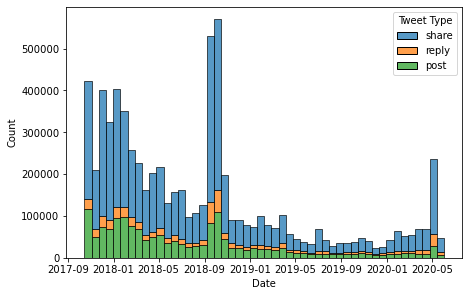

In [103]:
tweet_type_histogram(data, plot_kwargs = {"hue": "Tweet Type"})

<AxesSubplot:xlabel='Date', ylabel='value'>

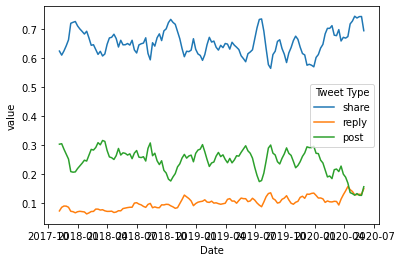

In [110]:
query = tweet_volume(data)
sns.lineplot(data = query, x = "Date", y = "value", hue = "Tweet Type")

As evidenced above, the majority of the tweets in the dataset occur in the months after Alyssa Milano [popularized the #MeToo hashtag](https://twitter.com/alyssa_milano/status/919659438700670976) in late 2017. There was also a significant spike around October of the following year surrounding the nomination of Brett Kavanaugh to the Supreme Court of the United States. 

#### Tweet Volume by Gender

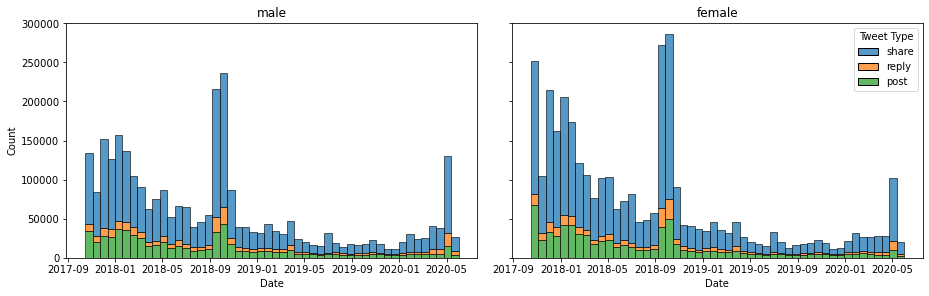

In [66]:
tweet_type_histogram(data, pivot_col = "Gender", fig_kwargs = {"sharey": True}, plot_kwargs = {"hue": "Tweet Type"})

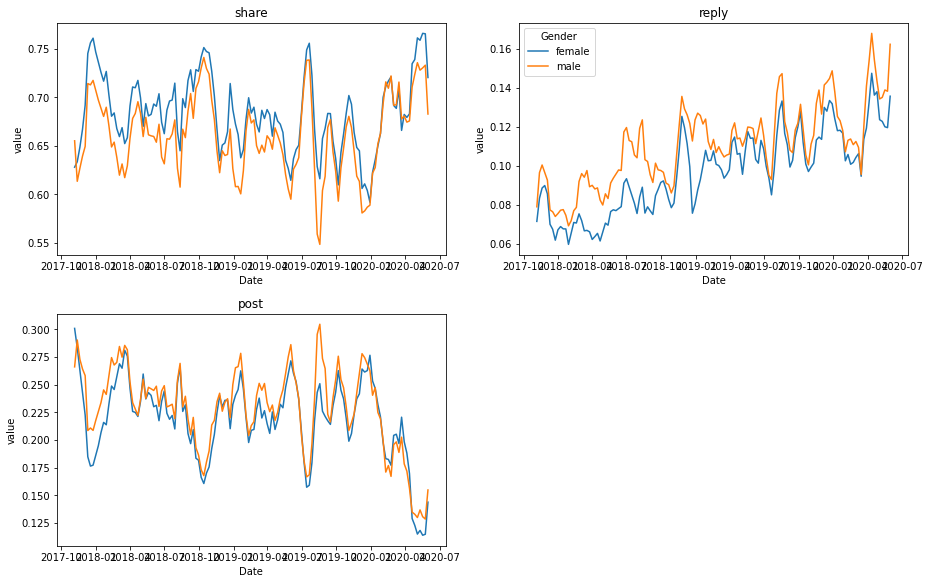

In [88]:
query = tweet_volume(data, ["Gender"])
tweet_topic_lineplot(query, pivot_col = "Tweet Type", plot_kwargs = {"hue": "Gender"})

Based on these charts, it appears that women engaged more frequently with the #MeToo movement than men. In total, women accounted for 3.5M total engagements in the dataset vs. 3M for males. 

#### Engagement by Gender

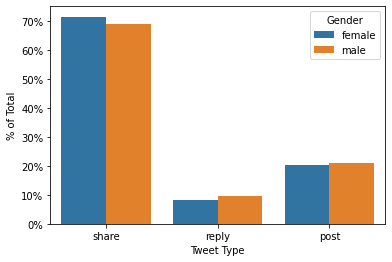

In [98]:
fig, ax = plt.subplots()
query = data.groupby("Gender")["Tweet Type"].value_counts(normalize = True)
query.name = "% of Total"
sns.barplot(data = query.reset_index(), x = "Tweet Type", y = "% of Total", hue = "Gender", ax = ax)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

A reasonable a priori hypothesis might have been that there are significant differences in engagement patterns for male and female users; based on these charts, however, the patterns are quite similar across the two. 

#### Engagement Distribution by Account Type

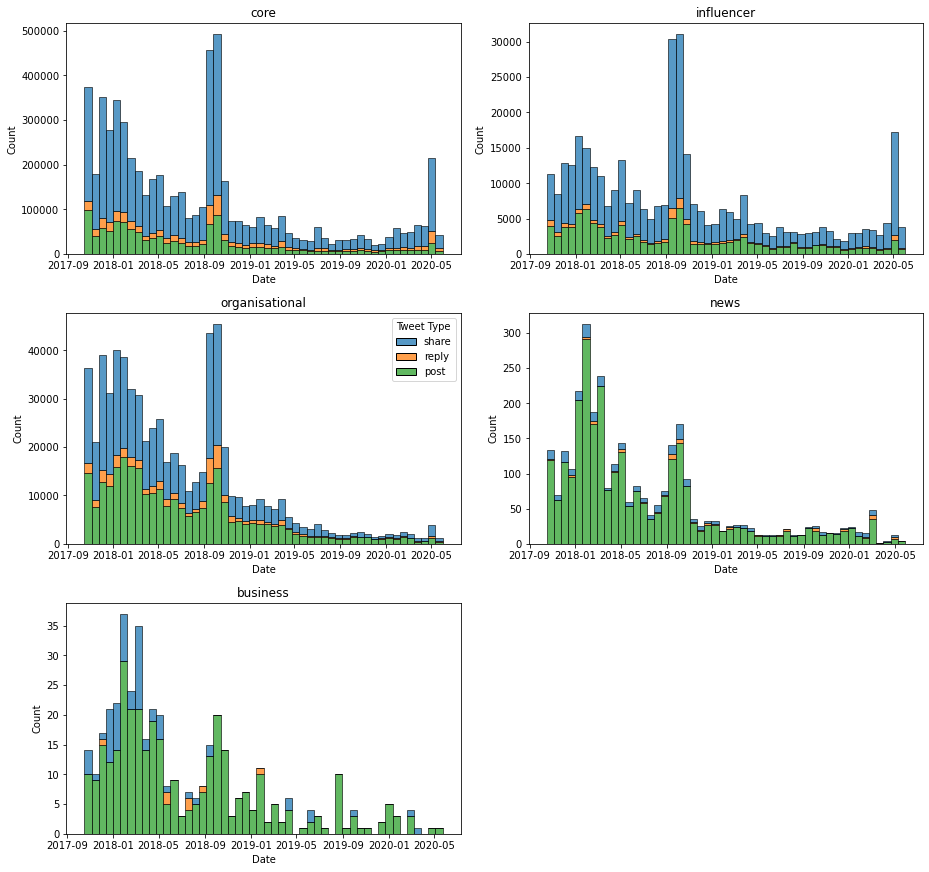

In [99]:
tweet_type_histogram(data, pivot_col = "Account Type", plot_kwargs = {"hue": "Tweet Type"})

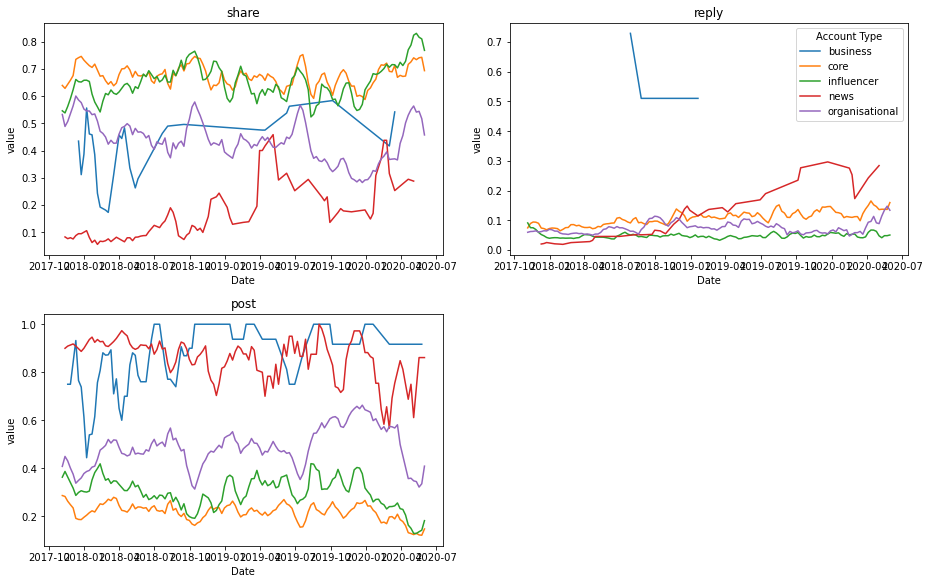

In [9]:
query = tweet_volume(data, ["Account Type"])
tweet_topic_lineplot(query, pivot_col = "Tweet Type", plot_kwargs = {"hue": "Account Type"})

Engagement behavior with the #MeToo movement certainly differs by account type, with organizations posting far more often (and retweeting much less so) than individual users. 

#### Interaction Frequency by Account Type

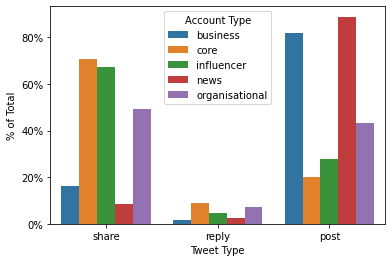

In [111]:
fig, ax = plt.subplots()
query = data.groupby("Account Type")["Tweet Type"].value_counts(normalize = True)
query.name = "% of Total"
sns.barplot(data = query.reset_index(), x = "Tweet Type", y = "% of Total", hue = "Account Type", ax = ax)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

### Influencers vs. Core Users

Tangential to the above observation that engagement behavior differs by account type is the hypothesis that "influencers" (i.e. users with high following) may engage differently than "core users" (i.e. users with low following). 

In order to test this hypothesis, we separate influencers from core users using a simple heuristic (here, individual accounts with greater than 20,000 following). 

These charts bear out a similar disparity in user behavior for core vs. influencer users. The latter engage with the movement much more organically (i.e. by creating their own posts), while the former engage primary through retweeting (although replying also seems to be a more common mode here as well). 

### Prevalent Topics Over Time

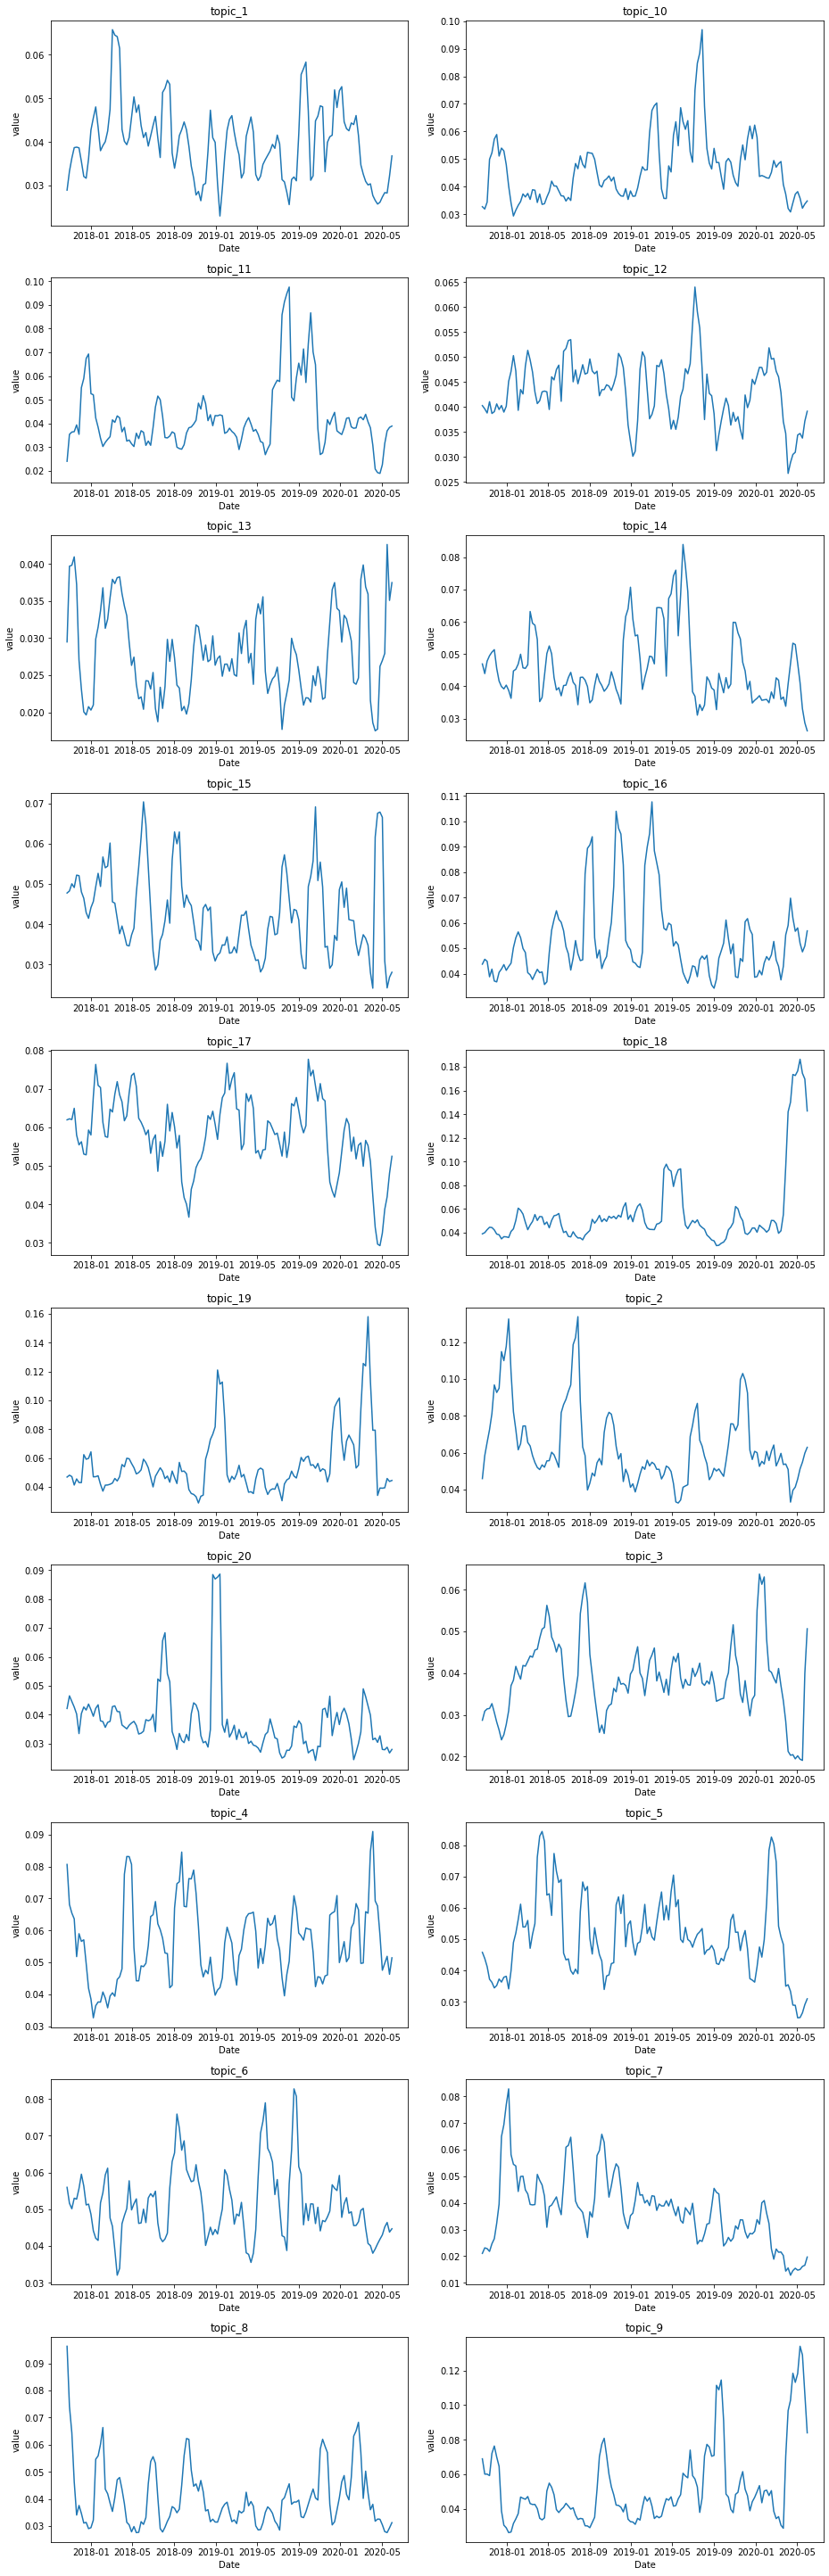

In [112]:
query = frequency_by_topic(data)
tweet_topic_lineplot(query, pivot_col = "topic")

In [113]:
query

,topic,level_1,Date,value
0,topic_1,1,2017-10-22,0.028965
1,topic_1,2,2017-10-29,0.033276
2,topic_1,3,2017-11-05,0.036276
3,topic_1,4,2017-11-12,0.038699
4,topic_1,5,2017-11-19,0.038816
...,...,...,...,...
2735,topic_9,1237,2020-05-03,0.118289
2736,topic_9,1238,2020-05-10,0.134136
2737,topic_9,1239,2020-05-17,0.129092
2738,topic_9,1240,2020-05-24,0.106150


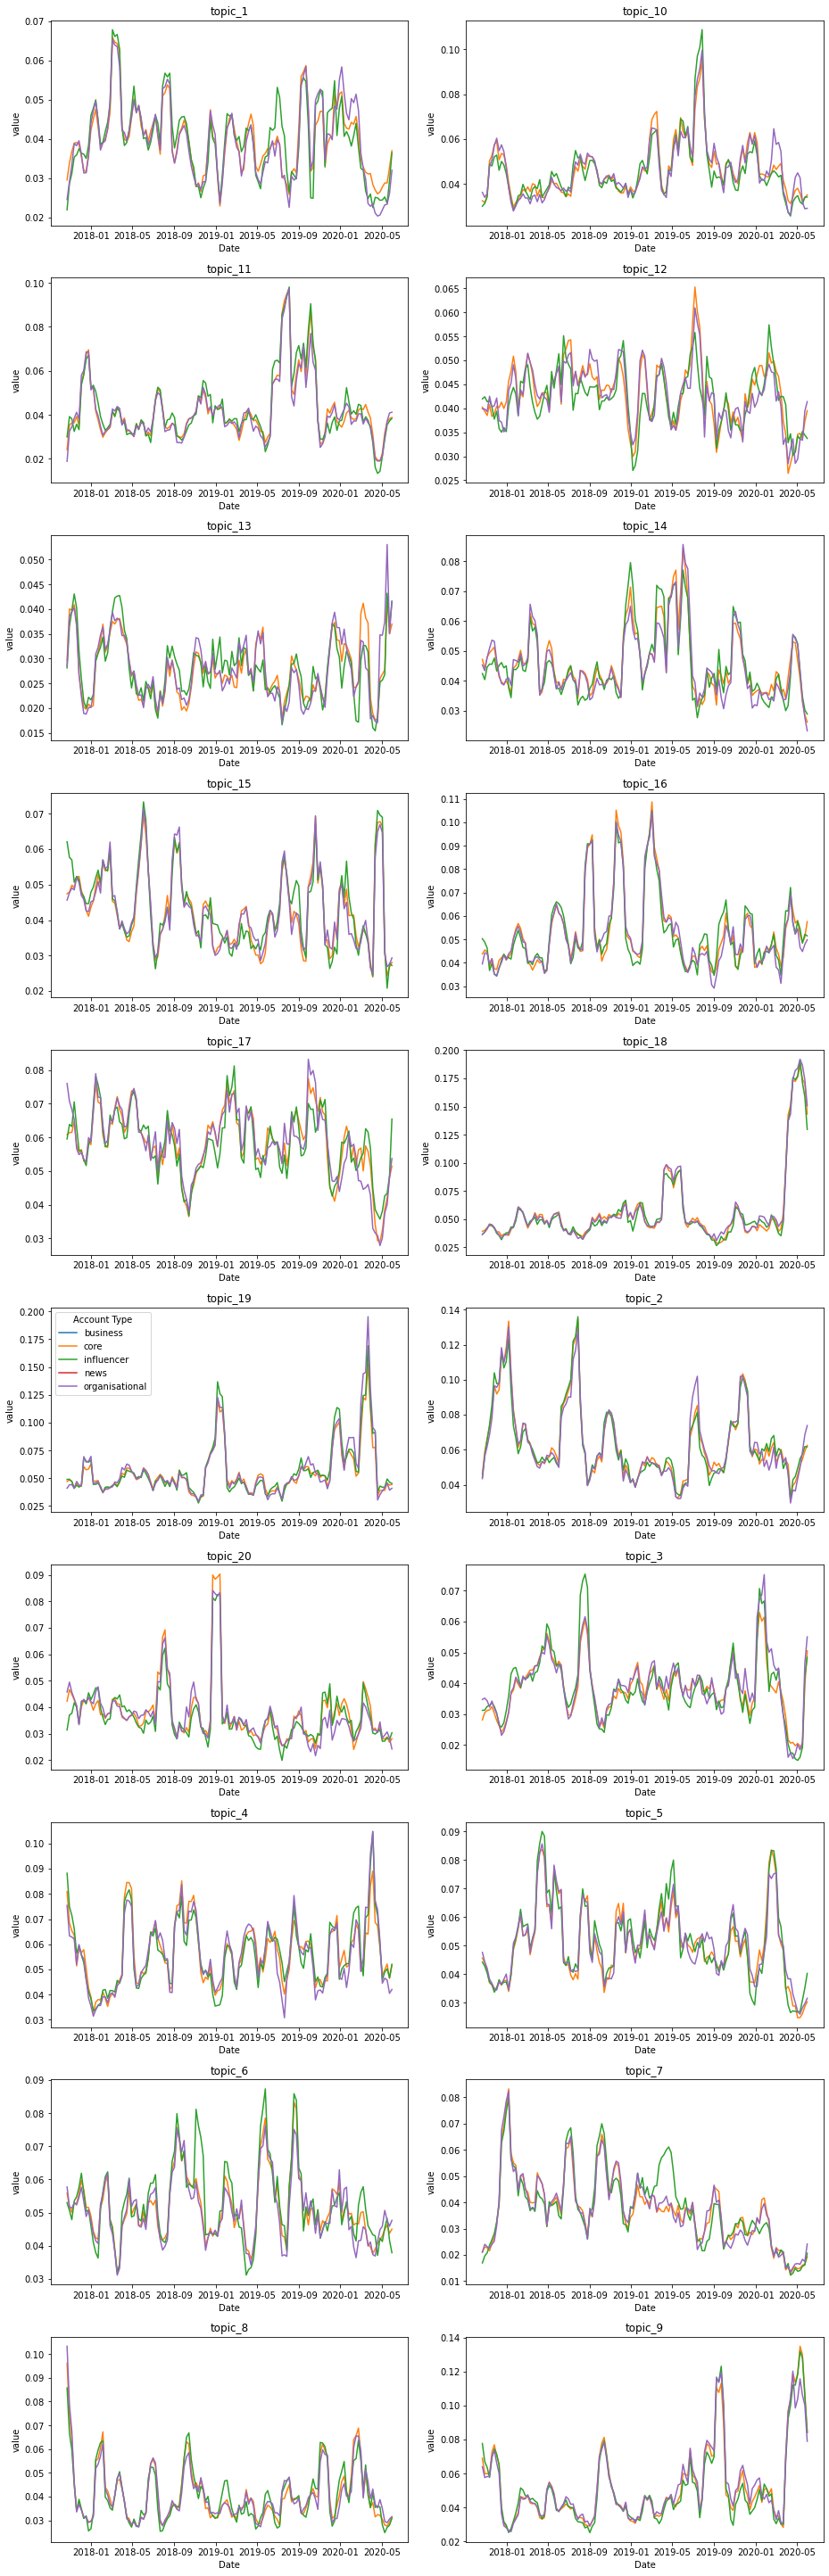

In [114]:
query = frequency_by_topic(data[~data["Account Type"].isin(["business", "news"])], groupings = ["Account Type"])
tweet_topic_lineplot(query, pivot_col = "topic", plot_kwargs = {"hue": "Account Type"})

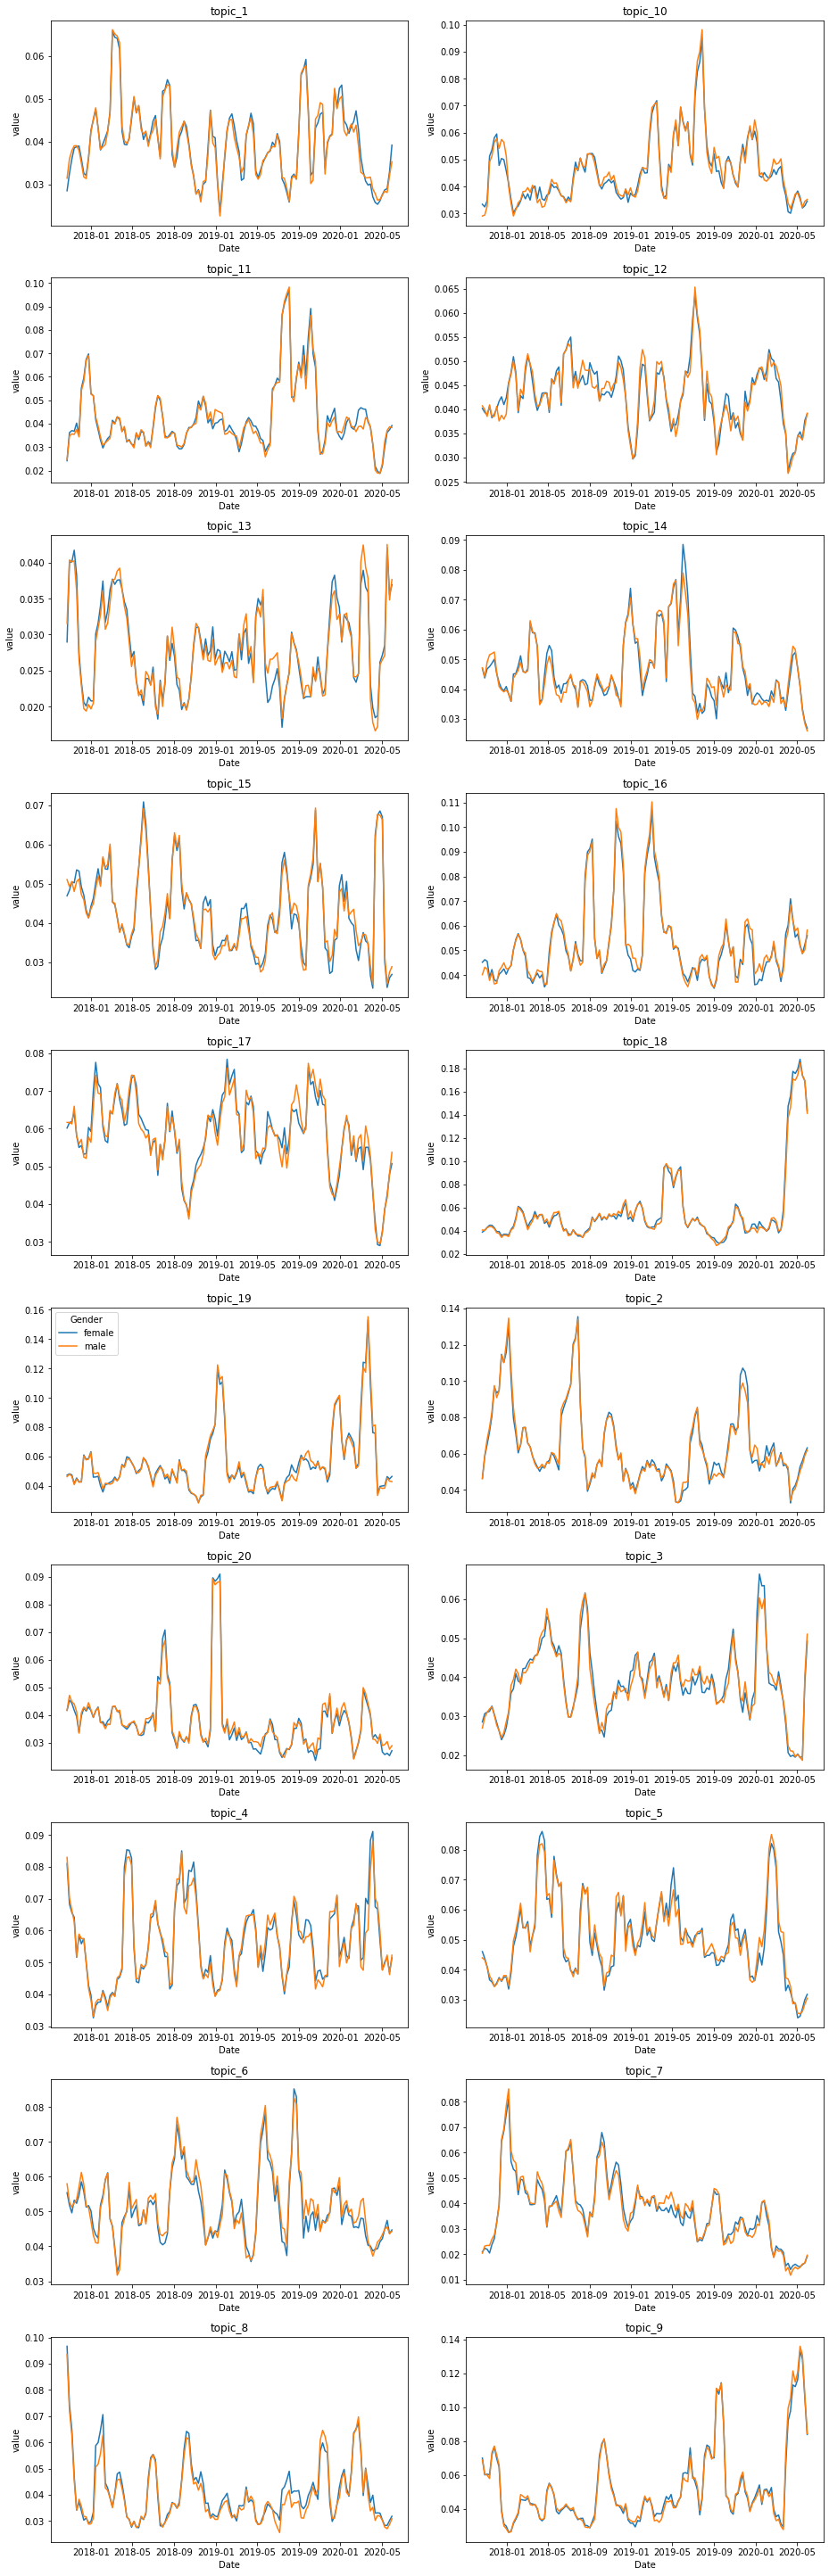

In [115]:
query = frequency_by_topic(data, groupings = ["Gender"])
tweet_topic_lineplot(query, pivot_col = "topic", plot_kwargs = {"hue": "Gender"})

In [117]:
data

,Date,Page Type,Author,Full Name,Full Text,Hashtags,Impact,Impressions,Tweet Type,Thread Author,...,topic_19,topic_20,screen,Gender,Account Type,followers_count,screen_originator,Gender_originator,Account Type_originator,followers_count_originator
0,2017-12-06 23:59:59,twitter,William82861606,William82861606 (William),funder conyers resigned franken resigning tomo...,"#trumpsexprobe, #metoo",0.0,282.0,share,funder,...,0.220628,0.000000,William82861606,male,core,2548.0,funder,male,influencer,336269.0
1,2017-12-06 23:59:58,twitter,Artis_Elemental,Artis_Elemental (ART...Is),alyssa_milano list sexual misconduct allegatio...,#metoo,24.5,5578.0,share,Alyssa_Milano,...,0.000000,0.000000,Artis_Elemental,male,core,7217.0,Alyssa_Milano,female,influencer,3698114.0
2,2017-12-06 23:59:57,twitter,lanah03,lanah03 (Laura Hopkins),deepinthehills sobbing silent longer,#metoo,5.4,2713.0,share,DeepInTheHills,...,0.010094,0.550865,lanah03,female,core,2775.0,NaN,NaN,NaN,NaN
3,2017-12-06 23:59:55,twitter,lidskawasaki,lidskawasaki (dearlordbabyjesus),alyssa_milano time asking franken resign senat...,"#timepersonoftheyear, #metoo",0.0,330.0,share,Alyssa_Milano,...,0.614572,0.000000,lidskawasaki,female,core,655.0,Alyssa_Milano,female,influencer,3698114.0
4,2017-12-06 23:59:54,twitter,IAmMeliLopez,IAmMeliLopez (Melissa Lopez),nycchr public hearing begun stories deserve he...,"#sexualharassment, #metoo",0.0,13.0,share,NYCCHR,...,0.000000,0.308982,IAmMeliLopez,female,core,18.0,NYCCHR,male,core,12572.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125054,2018-07-29 00:00:49,twitter,GreyCrossStudio,GreyCrossStudio (Grey Cross Studios),women china face unique challenges china women...,"#metoo, #china, #womensrights, #challenge, #re...",66.0,379407.0,post,NaN,...,NaN,NaN,GreyCrossStudio,female,core,16782.0,NaN,NaN,NaN,NaN
7125055,2018-07-29 00:00:32,twitter,505_303,505_303 (cheryle c),coagbfashion thenation require year old sign d...,"#metoo, #deadlinewh",0.0,324.0,share,COAGBFashion,...,NaN,NaN,505_303,female,core,631.0,COAGBFashion,female,core,3287.0
7125056,2018-07-29 00:00:11,twitter,techtionary,techtionary (CrossTalk),rally gun violence school shootings personal s...,"#gun, #violence, #school, #shootings, #safety,...",38.3,18861.0,post,NaN,...,NaN,NaN,techtionary,male,core,17562.0,NaN,NaN,NaN,NaN
7125057,2018-07-29 00:00:10,twitter,sheilafaye01_g,sheilafaye01_g (Sheila Humphries),zephyrteachout tomorrow noon cbs lay vision ne...,#metoo,0.0,723.0,share,ZephyrTeachout,...,NaN,NaN,sheilafaye01_g,female,core,565.0,ZephyrTeachout,NaN,organisational,90546.0


<AxesSubplot:xlabel='Account Type_originator', ylabel='Account Type'>

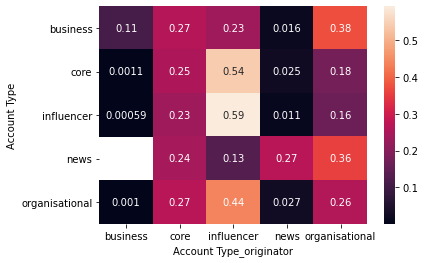

In [118]:
query = data.groupby("Account Type")["Account Type_originator"].value_counts(normalize = True).unstack(level = 1)
sns.heatmap(data = query, annot = True)

In [121]:
# def calc_pmi(data, x, y):
#     return np.log(data[data[

In [122]:
data["Gender"].value_counts(normalize = True)

female    0.541736
male      0.458264
Name: Gender, dtype: float64

In [123]:
# data[data["Gender"] == "male"]["

<AxesSubplot:xlabel='Account Type', ylabel='Account Type_originator'>

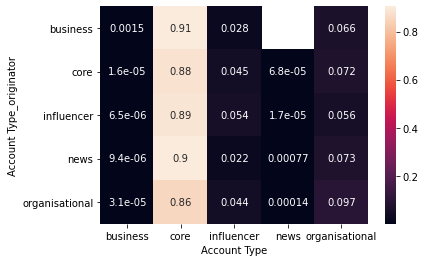

In [125]:
query = data.groupby("Account Type_originator")["Account Type"].value_counts(normalize = True).unstack(level = 1)
sns.heatmap(data = query, annot = True)

In [ ]:
# data.columns

In [126]:
test = data[data["screen"].str.lower() == "alyssa_milano"].sort_values(by = "Date")

In [127]:
data[data["Date"] < "2017-10-15"].shape

(0, 46)

In [129]:
data[data["Account Type"] == "organisational"]["Author"].value_counts().nlargest(20)

LeadingWPassion    12362
metoozoo            6587
XWIGS               6305
LoriHandrahan2      5948
AroundOMedia        3638
ggbrokensilence     3508
ReneNowb            3161
RestlessNews        2836
sexualassaulte1     2006
rockviewtees        1979
jenirwinauthor      1611
INSSAOnline         1607
GrassrootsDNC       1427
boyfacemedia        1009
MainChannel_         986
TurtleWoman777       890
NewAppleAwards       880
politiciandirec      858
agitpopworld         825
YourAnonRevolt       751
Name: Author, dtype: int64

In [130]:
data[data["Author"] == "LeadingWPassion"]

,Date,Page Type,Author,Full Name,Full Text,Hashtags,Impact,Impressions,Tweet Type,Thread Author,...,topic_19,topic_20,screen,Gender,Account Type,followers_count,screen_originator,Gender_originator,Account Type_originator,followers_count_originator
254826,2018-10-05 23:53:13,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),tries instead reacting learn respond empower g...,"#genderequality, #feminism, #metoo",47.7,62169.0,post,NaN,...,0.0,0.0,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
256350,2018-10-05 23:25:24,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),woman difference rock world genderequality fem...,"#genderequality, #feminism, #metoo",47.7,62169.0,post,NaN,...,0.0,0.0,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
257985,2018-10-05 22:56:22,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),domestic violence end domestic violence share ...,"#genderequality, #feminism, #metoo",47.7,62178.0,post,NaN,...,0.0,0.0,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
259343,2018-10-05 22:28:14,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),benefit soft skills woman men benefit learning...,"#genderequality, #feminism, #metoo",47.7,62176.0,post,NaN,...,0.0,0.0,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
260927,2018-10-05 21:57:20,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),types domestic violence learn genderequality f...,"#genderequality, #feminism, #metoo",47.7,62176.0,post,NaN,...,0.0,0.0,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124417,2018-07-29 02:17:16,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),men afraid strong women genderequality feminism,"#genderequality, #feminism, #metoo",48.0,63759.0,post,NaN,...,NaN,NaN,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
7124503,2018-07-29 01:49:14,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),possible estimated people worldwide exploited ...,"#genderequality, #feminism, #metoo",48.0,63756.0,post,NaN,...,NaN,NaN,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
7124630,2018-07-29 01:21:23,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),stop dwelling past charge life today genderequ...,"#genderequality, #feminism, #metoo",48.0,63753.0,post,NaN,...,NaN,NaN,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
7124781,2018-07-29 00:53:16,twitter,LeadingWPassion,LeadingWPassion (LeadingWithPassion™),femicide help prevent learn genderequality fem...,"#genderequality, #feminism, #metoo",48.0,63754.0,post,NaN,...,NaN,NaN,LeadingWPassion,NaN,organisational,50474.0,NaN,NaN,NaN,NaN
